# Identifikasi Suara Pembicara da Buka Tutup

In [47]:
import librosa
import soundfile as sf
import numpy as np
import os
import random
import string
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.svm import SVC
import os
import warnings

In [48]:
warnings.filterwarnings('ignore')

## Menyiapkan Data Audio

In [49]:
# buka_data_pitch_aug = "./data_audio/aug/buka/pitch/"
# buka_data_stretch_aug = "./data_audio/aug/buka/stretch/"
# buka_data_noise_aug = "./data_audio/aug/buka/noise/"aug
buka_data_real = "./data_audio/buka_wav_asli/"
buka_aug = "./data_aug/buka_aug/"
buka_data_fathan = "./data_audio/data_fathan/buka/"

# tutup_data_pitch_aug = "./data_audio/aug/buka/pitch/"
# tutup_data_stretch_aug = "./data_audio/aug/buka/stretch/"
# tutup_data_noise_aug = "./data_audio/aug/buka/noise/"
tutup_data_real = "./data_audio/tutup_wav_asli/"
tutup_aug = "./data_aug/tutup_aug/"
tutup_data_fathan = "./data_audio/data_fathan/tutup/"


In [50]:
data_aug = "./data_aug/"

In [51]:
buka_file_real = os.listdir("./data_audio/buka_wav_asli")

tutup_file_real = os.listdir("./data_audio/tutup_wav_asli")

tutup_file_fathan = os.listdir(tutup_data_fathan)
buka_file_fathan = os.listdir(buka_data_fathan)

In [52]:
# def augmentData(y, sr, path, name="buka", n_aug=3):
#     # Pastikan folder ada
#     for folder in ["pitch", "stretch", "noise", "combined"]:
#         os.makedirs(os.path.join(path, folder), exist_ok=True)

#     for i in range(n_aug):
#         random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=5))
        
#         # Pitch shift ±1 sampai ±2 step
#         n_steps = random.choice([-2, -1, 1, 2])
#         y_pitch = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
        
#         # Time stretch 0.9 - 1.1
#         rate = random.uniform(0.9, 1.1)
#         y_stretch = librosa.effects.time_stretch(y=y, rate=rate)
        
#         # Noise kecil
#         noise_std = random.uniform(0.003, 0.01)
#         y_noise = y + np.random.normal(0, noise_std, y.shape)

#         # Kombinasi pitch + stretch + noise
#         y_combined = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)
#         y_combined = librosa.effects.time_stretch(y=y_combined, rate=rate)
#         y_combined = y_combined + np.random.normal(0, noise_std, y_combined.shape)

#         # Simpan file
#         sf.write(os.path.join(path, f"{name}-pitch-{random_string}.wav"), y_pitch, sr)
#         sf.write(os.path.join(path, f"{name}-stretch-{random_string}.wav"), y_stretch, sr)
#         sf.write(os.path.join(path, f"{name}-noise-{random_string}.wav"), y_noise, sr)
#         sf.write(os.path.join(path, f"{name}-combined-{random_string}.wav"), y_combined, sr)

def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return [np.mean(mfcc, axis=1), np.std(mfcc, axis=1)]

def silent_trim(in_folder, list_file, out):
    for i in range(len(list_file)): 
        y1, sr = librosa.load("./data_audio/" + in_folder + list_file[i])
        y_trimmed, index = librosa.effects.trim(y1, top_db=30)
        sf.write("./data_audio/processed_trimed/" + out + "audio_trimmed_" + str(i) + ".wav", y_trimmed, sr)

def extract_temo(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    tempo = librosa.feature.tempo(y=y, sr=sr)
    return tempo

def extract_spectral_centroid(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    return [np.mean(centroid, axis=1), np.std(centroid, axis=1)]

def extract_rms(file_path):
    y, sr = librosa.load(file_path)
    rms = librosa.feature.rms(y=y)
    return [np.mean(rms, axis=1), np.std(rms, axis=1)]

def extract_tonetz(file_path):
    y, sr = librosa.load(file_path)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return [np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1)]

def extract_mel(file_path):
    y, sr = librosa.load(file_path)
    tonnetz = librosa.feature.melspectrogram(y=y, sr=sr)
    return [np.mean(tonnetz, axis=1), np.std(tonnetz, axis=1)]

def extract_std(file_path):
    y, sr = librosa.load(file_path)
    return np.mean(y)

def extract_mean(file_path):
    y, sr = librosa.load(file_path)
    return np.std(y)

In [53]:
silent_trim("data_fathan/tutup/", tutup_file_fathan, "data_fathan/tutup/")
silent_trim("data_fathan/buka/", buka_file_fathan, "data_fathan/buka/")
silent_trim("tutup_wav_asli/", tutup_file_real, "tutup_file/")
silent_trim("buka_wav_asli/", buka_file_real, "buka_file/")

In [54]:
buka_audio_trimed = os.listdir("./data_audio/processed_trimed/buka_file/")
tutup_audio_trimed = os.listdir("./data_audio/processed_trimed/tutup_file/")
tutup_fathan_trimed = os.listdir("./data_audio/processed_trimed/data_fathan/tutup/")
buka_fathan_trimed = os.listdir("./data_audio/processed_trimed/data_fathan/buka/")

In [55]:
# for audio_buka in buka_file_real:
#     y, sr = librosa.load(buka_data_real + audio_buka, sr=16000)
#     augmentData(y, sr, "./data_aug/buka_aug")z

In [56]:
# for audio_tutup in tutup_file_real:
#     y, sr = librosa.load(tutup_data_real + audio_tutup, sr=16000)
#     augmentData(y, sr, "./data_aug/tutup_aug" , name="tutup")

In [57]:
buka_file_aug = os.listdir("./data_aug/buka_aug/")
buka_file_noise_aug = os.listdir("./data_audio/aug/buka/noise/")

tutup_file_aug = os.listdir("./data_aug/tutup_aug/")
tutup_file_noise_aug = os.listdir("./data_audio/aug/buka/noise/")

In [58]:
all_data_buka = [
    # *[buka_data_real  + real for real in buka_file_real],
    *["./data_audio/processed_trimed/buka_file/"  + trimed for trimed in buka_audio_trimed],
    *["./data_audio/processed_trimed/data_fathan/buka/"  + trimed for trimed in buka_fathan_trimed],
    # *[buka_aug + pitch for pitch in buka_file_aug],
    # *[buka_data_stretch_aug + stretch for stretch in buka_file_stretch_aug],
    # *[buka_data_noise_aug + noise for noise in buka_file_noise_aug]
]


all_data_tutup = [
    # *[tutup_data_real  + real for real in tutup_file_real],
    *["./data_audio/processed_trimed/tutup_file/"  + trimed for trimed in tutup_audio_trimed],
    *["./data_audio/processed_trimed/data_fathan/tutup/"  + trimed for trimed in tutup_fathan_trimed],
    # *[tutup_aug + pitch for pitch in tutup_file_aug],
    # *[tutup_data_stretch_aug + stretch for stretch in tutup_file_stretch_aug],
    # *[tutup_data_noise_aug + noise for noise in tutup_file_noise_aug]
]

all_data_zanuar = [
    *["./data_audio/processed_trimed/tutup_file/"  + trimed for trimed in tutup_audio_trimed],
    *["./data_audio/processed_trimed/buka_file/"  + trimed for trimed in buka_audio_trimed],
]

all_data_fathan = [
    *["./data_audio/processed_trimed/data_fathan/buka/"  + trimed for trimed in buka_fathan_trimed],
    *["./data_audio/processed_trimed/data_fathan/tutup/"  + trimed for trimed in tutup_fathan_trimed],
]

## Membuat Klasifikasi Suara Orang

In [59]:
mfcc_mean_arr = []
mfcc_std_arr = []
tempo_arr = []
centroid_mean_arr = []
centroid_std_arr = []
rms_mean_arr = []
rms_std_arr = []
tonetz_mean_arr = []
tonetz_std_arr = []
std_arr = []
mel_mean_arr = []
mel_std_arr = []
mean_arr = []
label = []

for zanuar in all_data_zanuar:
    mfcc = extract_mfcc(zanuar)
    tempo = extract_temo(zanuar)
    centroid = extract_spectral_centroid(zanuar)
    rms = extract_rms(zanuar)
    mel = extract_mel(zanuar)
    tonetz = extract_tonetz(zanuar)
    std_arr.append([extract_std(zanuar)])
    mean_arr.append([extract_mean(zanuar)])
    
    mfcc_mean_arr.append(mfcc[0])
    mfcc_std_arr.append(mfcc[1])
    tempo_arr.append(tempo)
    centroid_mean_arr.append(centroid[0])
    centroid_std_arr.append(centroid[1])
    rms_mean_arr.append(rms[0])
    rms_std_arr.append(rms[1])
    tonetz_mean_arr.append(tonetz[0])
    tonetz_std_arr.append(tonetz[1])
    mel_mean_arr.append(mel[0])
    mel_std_arr.append(mel[1])
    label.append(["zanuar"])
    
dataset_zanuar = np.hstack((
    std_arr,
    mean_arr,
    mfcc_mean_arr,
    mfcc_std_arr,
    tempo_arr,
    centroid_mean_arr,
    centroid_std_arr,
    rms_mean_arr,
    rms_std_arr,
    tonetz_mean_arr,
    tonetz_std_arr,
    mel_mean_arr,
    mel_std_arr,
    label
))

dataset_zanuar.shape



(200, 302)

In [60]:
mfcc_mean_arr = []
mfcc_std_arr = []
tempo_arr = []
centroid_mean_arr = []
centroid_std_arr = []
rms_mean_arr = []
rms_std_arr = []
tonetz_mean_arr = []
tonetz_std_arr = []
std_arr = []
mel_mean_arr = []
mel_std_arr = []
mean_arr = []
label = []

for fathan in all_data_fathan:
    mfcc = extract_mfcc(fathan)
    tempo = extract_temo(fathan)
    centroid = extract_spectral_centroid(fathan)
    rms = extract_rms(fathan)
    mel = extract_mel(fathan)
    tonetz = extract_tonetz(fathan)
    std_arr.append([extract_std(fathan)])
    mean_arr.append([extract_mean(fathan)])
    
    mfcc_mean_arr.append(mfcc[0])
    mfcc_std_arr.append(mfcc[1])
    tempo_arr.append(tempo)
    centroid_mean_arr.append(centroid[0])
    centroid_std_arr.append(centroid[1])
    rms_mean_arr.append(rms[0])
    rms_std_arr.append(rms[1])
    tonetz_mean_arr.append(tonetz[0])
    tonetz_std_arr.append(tonetz[1])
    mel_mean_arr.append(mel[0])
    mel_std_arr.append(mel[1])
    label.append(["fathan"])
    
dataset_fathan = np.hstack((
    std_arr,
    mean_arr,
    mfcc_mean_arr,
    mfcc_std_arr,
    tempo_arr,
    centroid_mean_arr,
    centroid_std_arr,
    rms_mean_arr,
    rms_std_arr,
    tonetz_mean_arr,
    tonetz_std_arr,
    mel_mean_arr,
    mel_std_arr,
    label
))

dataset_fathan.shape

(200, 302)

In [61]:
columns = ["std", "mean", *[f"mfcc_mean_" + str(i + 1) for i in range(len(mfcc_mean_arr[0]))], *[f"mfcc_std_" + str(i + 1) for i in range(len(mfcc_std_arr[0]))], "tempo", *[f"centroid_mean_" + str(i + 1) for i in range(len(centroid_mean_arr[0]))], *[f"centroid_std_" + str(i + 1) for i in range(len(centroid_std_arr[0]))], *[f"rms_mean_" + str(i + 1) for i in range(len(rms_mean_arr[0]))], *[f"rms_std_" + str(i+1) for i in range(len(rms_std_arr[0]))], *[f"tonetz_mean" + str(i+1) for i in range(len(tonetz_mean_arr[0]))], *[f"tonetz_std_" + str(i+1) for i in range(len(tonetz_std_arr[0]))], *[f"mel_mean_" + str(i+1) for i in range(len(mel_mean_arr[0]))], *[f"mel_std_" + str(i+1) for i in range(len(mel_mean_arr[1]))], "label"]

dataset = pd.DataFrame(np.vstack((dataset_zanuar, dataset_fathan)), columns=columns)

dataset

,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_120,mel_std_121,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label
0,-1.3912425e-05,0.011563646,-477.02985,123.870926,31.23104,21.628147,2.6245275,8.934891,2.8156931,-4.233397,...,1.361756e-06,1.0238781e-06,8.5486295e-07,1.1646457e-06,9.721465e-07,1.0683531e-06,9.962517e-07,5.1448353e-07,4.4327187e-08,zanuar
1,2.9381583e-06,0.009167008,-503.73605,120.55202,35.477066,24.092226,6.434122,17.13923,-3.7508135,-9.067448,...,1.2261043e-05,9.564429e-06,8.407773e-06,6.7792535e-06,5.472032e-06,9.600722e-06,9.554846e-06,1.3589842e-06,2.4014216e-07,zanuar
2,-2.6915755e-05,0.014714078,-462.03696,143.78949,31.145885,19.626184,-5.1409583,10.1631565,2.2667918,-6.724922,...,2.1681865e-06,5.3108133e-06,4.375502e-06,2.945784e-06,1.703815e-06,1.2679221e-06,9.854289e-07,4.3997477e-07,7.498289e-08,zanuar
3,-3.6700567e-05,0.01290706,-487.8172,134.42647,22.022692,21.886986,-12.475644,11.126036,12.090064,-4.6893053,...,1.7976689e-06,9.713395e-07,1.2753699e-06,1.4913594e-06,3.1070072e-06,1.3868356e-06,7.5324897e-07,1.0231956e-06,1.4028984e-07,zanuar
4,-1.8248955e-05,0.01100796,-500.71594,133.7235,23.189465,22.146875,-1.1075821,12.363,6.9701858,-7.8972907,...,1.011622e-06,9.558171e-07,1.1023789e-06,1.5762237e-06,2.3345715e-06,1.4412492e-06,1.029332e-06,7.4506096e-07,1.961467e-07,zanuar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.00023816079,0.02840689,-419.9184,96.09794,43.513332,24.412283,3.4053867,24.237545,-9.355809,-15.427906,...,0.0004276133,0.0003654324,0.00041633457,0.0001343197,3.0467036e-05,3.3838016e-05,4.9995188e-06,4.098899e-06,4.3857048e-07,fathan
396,-0.00025117397,0.03714193,-362.42865,105.70649,36.13,12.106636,-3.3258762,31.12015,-29.63329,-35.780758,...,0.00089188124,0.00038904065,0.00031429066,0.00013046991,3.3043783e-05,3.1124986e-05,2.1348455e-05,8.500945e-06,2.14967e-07,fathan
397,-0.0002456648,0.03503957,-364.8346,97.0676,34.59552,16.981377,-0.8830796,28.7523,-26.535778,-31.677406,...,0.00028550182,0.00022740524,0.0002706283,3.993777e-05,1.6350767e-05,1.238361e-05,6.885567e-06,3.6844324e-06,3.3721946e-07,fathan
398,-0.00023603169,0.03278271,-376.91446,100.33139,36.553562,23.412449,-0.7632972,32.42795,-26.514513,-30.365091,...,0.00024938822,0.00028553235,0.00016753685,3.147752e-05,4.9862683e-06,6.0430452e-06,6.213851e-06,1.6289556e-06,2.1802677e-07,fathan


In [62]:
dataset.to_csv("./dataset/zanuar_fathan.csv", index=False)

### Outlier Detection

In [63]:
from pycaret.anomaly import *

audio_zanuar_fathan = pd.read_csv("./dataset/zanuar_fathan.csv")

s = setup(data=audio_zanuar_fathan)

abod_model = create_model("abod", fraction=0.05)

df_abod = assign_model(abod_model)

df_abod

,Description,Value
0,Session id,2519
1,Original data shape,"(400, 302)"
2,Transformed data shape,"(400, 302)"
3,Numeric features,301
4,Categorical features,1
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label,Anomaly,Anomaly_Score
0,-0.000014,0.011564,-477.029846,123.870926,31.231039,21.628147,2.624527,8.934891,2.815693,-4.233397,...,8.548629e-07,0.000001,9.721465e-07,1.068353e-06,9.962517e-07,5.144835e-07,4.432719e-08,zanuar,0,-6.453454e-09
1,0.000003,0.009167,-503.736053,120.552017,35.477066,24.092226,6.434122,17.139231,-3.750813,-9.067448,...,8.407773e-06,0.000007,5.472032e-06,9.600722e-06,9.554846e-06,1.358984e-06,2.401422e-07,zanuar,0,-4.388857e-09
2,-0.000027,0.014714,-462.036957,143.789490,31.145885,19.626184,-5.140958,10.163157,2.266792,-6.724922,...,4.375502e-06,0.000003,1.703815e-06,1.267922e-06,9.854289e-07,4.399748e-07,7.498289e-08,zanuar,0,-1.149600e-08
3,-0.000037,0.012907,-487.817200,134.426468,22.022692,21.886986,-12.475644,11.126036,12.090064,-4.689305,...,1.275370e-06,0.000001,3.107007e-06,1.386836e-06,7.532490e-07,1.023196e-06,1.402898e-07,zanuar,0,-8.236920e-09
4,-0.000018,0.011008,-500.715942,133.723495,23.189465,22.146875,-1.107582,12.363000,6.970186,-7.897291,...,1.102379e-06,0.000002,2.334571e-06,1.441249e-06,1.029332e-06,7.450610e-07,1.961467e-07,zanuar,0,-8.567694e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000238,0.028407,-419.918396,96.097939,43.513332,24.412283,3.405387,24.237545,-9.355809,-15.427906,...,4.163346e-04,0.000134,3.046704e-05,3.383802e-05,4.999519e-06,4.098899e-06,4.385705e-07,fathan,0,-6.946441e-09
396,-0.000251,0.037142,-362.428650,105.706490,36.130001,12.106636,-3.325876,31.120150,-29.633289,-35.780758,...,3.142907e-04,0.000130,3.304378e-05,3.112499e-05,2.134845e-05,8.500945e-06,2.149670e-07,fathan,0,-5.427290e-09
397,-0.000246,0.035040,-364.834595,97.067596,34.595520,16.981377,-0.883080,28.752300,-26.535778,-31.677406,...,2.706283e-04,0.000040,1.635077e-05,1.238361e-05,6.885567e-06,3.684432e-06,3.372195e-07,fathan,0,-1.052222e-08
398,-0.000236,0.032783,-376.914459,100.331390,36.553562,23.412449,-0.763297,32.427952,-26.514513,-30.365091,...,1.675369e-04,0.000031,4.986268e-06,6.043045e-06,6.213851e-06,1.628956e-06,2.180268e-07,fathan,0,-4.881677e-09


In [64]:
non_anomaly_data = df_abod[df_abod["Anomaly"] == 0]
non_anomaly_data

,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label,Anomaly,Anomaly_Score
0,-0.000014,0.011564,-477.029846,123.870926,31.231039,21.628147,2.624527,8.934891,2.815693,-4.233397,...,8.548629e-07,0.000001,9.721465e-07,1.068353e-06,9.962517e-07,5.144835e-07,4.432719e-08,zanuar,0,-6.453454e-09
1,0.000003,0.009167,-503.736053,120.552017,35.477066,24.092226,6.434122,17.139231,-3.750813,-9.067448,...,8.407773e-06,0.000007,5.472032e-06,9.600722e-06,9.554846e-06,1.358984e-06,2.401422e-07,zanuar,0,-4.388857e-09
2,-0.000027,0.014714,-462.036957,143.789490,31.145885,19.626184,-5.140958,10.163157,2.266792,-6.724922,...,4.375502e-06,0.000003,1.703815e-06,1.267922e-06,9.854289e-07,4.399748e-07,7.498289e-08,zanuar,0,-1.149600e-08
3,-0.000037,0.012907,-487.817200,134.426468,22.022692,21.886986,-12.475644,11.126036,12.090064,-4.689305,...,1.275370e-06,0.000001,3.107007e-06,1.386836e-06,7.532490e-07,1.023196e-06,1.402898e-07,zanuar,0,-8.236920e-09
4,-0.000018,0.011008,-500.715942,133.723495,23.189465,22.146875,-1.107582,12.363000,6.970186,-7.897291,...,1.102379e-06,0.000002,2.334571e-06,1.441249e-06,1.029332e-06,7.450610e-07,1.961467e-07,zanuar,0,-8.567694e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000238,0.028407,-419.918396,96.097939,43.513332,24.412283,3.405387,24.237545,-9.355809,-15.427906,...,4.163346e-04,0.000134,3.046704e-05,3.383802e-05,4.999519e-06,4.098899e-06,4.385705e-07,fathan,0,-6.946441e-09
396,-0.000251,0.037142,-362.428650,105.706490,36.130001,12.106636,-3.325876,31.120150,-29.633289,-35.780758,...,3.142907e-04,0.000130,3.304378e-05,3.112499e-05,2.134845e-05,8.500945e-06,2.149670e-07,fathan,0,-5.427290e-09
397,-0.000246,0.035040,-364.834595,97.067596,34.595520,16.981377,-0.883080,28.752300,-26.535778,-31.677406,...,2.706283e-04,0.000040,1.635077e-05,1.238361e-05,6.885567e-06,3.684432e-06,3.372195e-07,fathan,0,-1.052222e-08
398,-0.000236,0.032783,-376.914459,100.331390,36.553562,23.412449,-0.763297,32.427952,-26.514513,-30.365091,...,1.675369e-04,0.000031,4.986268e-06,6.043045e-06,6.213851e-06,1.628956e-06,2.180268e-07,fathan,0,-4.881677e-09


In [65]:
non_anomaly_data.drop("Anomaly", axis=1)
non_anomaly_data.drop("Anomaly_Score", axis=1)
non_anomaly_data.to_csv("./dataset/clean_speaker_identifikasi.csv")

### Penyebaran Data

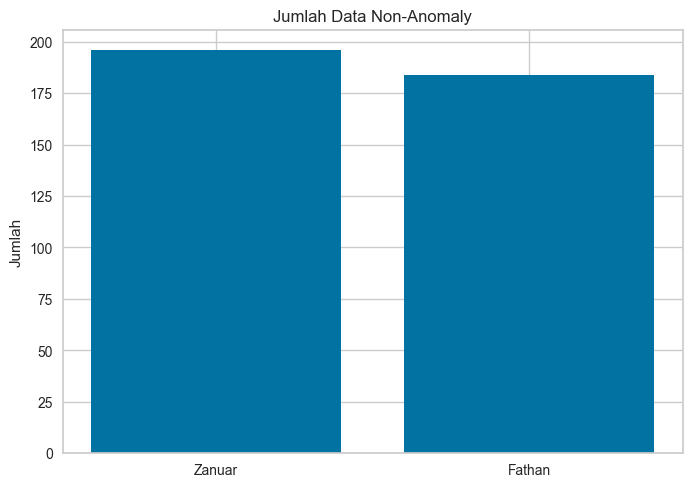

,zanuar,fahtan
0,196,184


In [66]:
import matplotlib.pyplot as plt

buka_non_anomaly = non_anomaly_data[non_anomaly_data["label"] == "zanuar"]
tutup_non_anomaly = non_anomaly_data[non_anomaly_data["label"] == "fathan"]

plt.bar(["Zanuar", "Fathan"], [buka_non_anomaly.shape[0], tutup_non_anomaly.shape[0]])

plt.title("Jumlah Data Non-Anomaly")
plt.ylabel("Jumlah")


plt.show()

pd.DataFrame([[buka_non_anomaly.shape[0], tutup_non_anomaly.shape[0]]], columns=["zanuar", "fahtan"])

### Korelasis Fitur

In [67]:
def corel_check(x, y, treshold):
    data_res = []
    corel_arr = []
    for data in x:
        corel = np.mean(np.corrcoef(x[data], y))
        # corel = corelation(x[data], y)
        corel_arr.append(corel)
        if corel > treshold :
            data_res.append(data)
            
    return data_res

In [68]:
label = non_anomaly_data["label"].map({
    'zanuar': 0,
    'fathan': 1
})
fitur = non_anomaly_data.drop("label", axis=1).drop("Anomaly_Score", axis=1).drop("Anomaly", axis=1)

In [69]:
fitur_bearkorelasi = corel_check(fitur, label, 0.7)
len(fitur_bearkorelasi)

117

In [70]:
fitur_bearkorelasi

['mean',
 'mfcc_mean_1',
 'mfcc_mean_3',
 'mfcc_mean_4',
 'mfcc_mean_5',
 'mfcc_mean_9',
 'mfcc_mean_13',
 'mfcc_std_7',
 'mfcc_std_8',
 'mfcc_std_9',
 'centroid_mean_1',
 'rms_mean_1',
 'rms_std_1',
 'tonetz_std_6',
 'mel_mean_5',
 'mel_mean_6',
 'mel_mean_7',
 'mel_mean_11',
 'mel_mean_12',
 'mel_mean_13',
 'mel_mean_15',
 'mel_mean_18',
 'mel_mean_19',
 'mel_mean_20',
 'mel_mean_51',
 'mel_mean_52',
 'mel_mean_53',
 'mel_mean_62',
 'mel_mean_65',
 'mel_mean_76',
 'mel_mean_77',
 'mel_mean_83',
 'mel_mean_84',
 'mel_mean_85',
 'mel_mean_86',
 'mel_mean_87',
 'mel_mean_88',
 'mel_mean_89',
 'mel_mean_93',
 'mel_mean_94',
 'mel_mean_95',
 'mel_mean_96',
 'mel_mean_97',
 'mel_mean_98',
 'mel_mean_99',
 'mel_mean_100',
 'mel_mean_101',
 'mel_mean_102',
 'mel_mean_103',
 'mel_mean_104',
 'mel_mean_105',
 'mel_mean_106',
 'mel_mean_107',
 'mel_mean_108',
 'mel_mean_109',
 'mel_mean_110',
 'mel_mean_111',
 'mel_mean_112',
 'mel_mean_117',
 'mel_mean_118',
 'mel_mean_119',
 'mel_mean_120',
 

### Model Training

In [71]:
dataset = pd.read_csv("./dataset/clean_speaker_identifikasi.csv")

X = dataset[fitur_bearkorelasi]
y = dataset["label"]

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict_proba(scaler.transform(X_test))

In [72]:
y_pred

array([[0.   , 1.   ],
       [0.925, 0.075],
       [0.045, 0.955],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.05 , 0.95 ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.995, 0.005],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.995, 0.005],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.005, 0.995],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [0.   , 1.   ],
       [1. 

### Menyimpan Model

In [73]:
columns = columns[:-1]
# joblib.dump(rf_model, "../../audio_streamlit/svm_speaker_identifikasi.pkl")
# joblib.dump(scaler, "../../audio_streamlit/scale_speaker_identifikasi.pkl")
# joblib.dump(fitur_bearkorelasi, "../../audio_streamlit/fitur_berkorelasi_speaker_identifikasi.pkl")
# joblib.dump(columns, "../../audio_streamlit/columns_speaker_identifikasi.pkl")

## Membuat Klasifikasi Suara Buka Tutup

In [74]:
mfcc_mean_arr = []
mfcc_std_arr = []
tempo_arr = []
centroid_mean_arr = []
centroid_std_arr = []
rms_mean_arr = []
rms_std_arr = []
tonetz_mean_arr = []
tonetz_std_arr = []
std_arr = []
mel_mean_arr = []
mel_std_arr = []
mean_arr = []
label = []

for buka in all_data_buka:
    mfcc = extract_mfcc(buka)
    tempo = extract_temo(buka)
    centroid = extract_spectral_centroid(buka)
    rms = extract_rms(buka)
    mel = extract_mel(buka)
    tonetz = extract_tonetz(buka)
    std_arr.append([extract_std(buka)])
    mean_arr.append([extract_mean(buka)])
    
    mfcc_mean_arr.append(mfcc[0])
    mfcc_std_arr.append(mfcc[1])
    tempo_arr.append(tempo)
    centroid_mean_arr.append(centroid[0])
    centroid_std_arr.append(centroid[1])
    rms_mean_arr.append(rms[0])
    rms_std_arr.append(rms[1])
    tonetz_mean_arr.append(tonetz[0])
    tonetz_std_arr.append(tonetz[1])
    mel_mean_arr.append(mel[0])
    mel_std_arr.append(mel[1])
    label.append(["buka"])
    
dataset_buka = np.hstack((
    std_arr,
    mean_arr,
    mfcc_mean_arr,
    mfcc_std_arr,
    tempo_arr,
    centroid_mean_arr,
    centroid_std_arr,
    rms_mean_arr,
    rms_std_arr,
    tonetz_mean_arr,
    tonetz_std_arr,
    mel_mean_arr,
    mel_std_arr,
    label
))

dataset_buka.shape

(200, 302)

In [ ]:
mfcc_mean_arr = []
mfcc_std_arr = []
tempo_arr = []
centroid_mean_arr = []
centroid_std_arr = []
rms_mean_arr = []
rms_std_arr = []
tonetz_mean_arr = []
tonetz_std_arr = []
std_arr = []
mel_mean_arr = []
mel_std_arr = []
mean_arr = []
label = []

for tutup in all_data_tutup:
    mfcc = extract_mfcc(tutup)
    tempo = extract_temo(tutup)
    centroid = extract_spectral_centroid(tutup)
    rms = extract_rms(tutup)
    mel = extract_mel(tutup)
    tonetz = extract_tonetz(tutup)
    std_arr.append([extract_std(tutup)])
    mean_arr.append([extract_mean(tutup)])
    
    mfcc_mean_arr.append(mfcc[0])
    mfcc_std_arr.append(mfcc[1])
    tempo_arr.append(tempo)
    centroid_mean_arr.append(centroid[0])
    centroid_std_arr.append(centroid[1])
    rms_mean_arr.append(rms[0])
    rms_std_arr.append(rms[1])
    tonetz_mean_arr.append(tonetz[0])
    tonetz_std_arr.append(tonetz[1])
    mel_mean_arr.append(mel[0])
    mel_std_arr.append(mel[1])
    label.append(["tutup"])
    
dataset_tutup = np.hstack((
    std_arr,
    mean_arr,
    mfcc_mean_arr,
    mfcc_std_arr,
    tempo_arr,
    centroid_mean_arr,
    centroid_std_arr,
    rms_mean_arr,
    rms_std_arr,
    tonetz_mean_arr,
    tonetz_std_arr,
    mel_mean_arr,
    mel_std_arr,
    label
))

dataset_tutup.shape

(200, 302)

In [76]:
columns = ["std", "mean", *[f"mfcc_mean_" + str(i + 1) for i in range(len(mfcc_mean_arr[0]))], *[f"mfcc_std_" + str(i + 1) for i in range(len(mfcc_std_arr[0]))], "tempo", *[f"centroid_mean_" + str(i + 1) for i in range(len(centroid_mean_arr[0]))], *[f"centroid_std_" + str(i + 1) for i in range(len(centroid_std_arr[0]))], *[f"rms_mean_" + str(i + 1) for i in range(len(rms_mean_arr[0]))], *[f"rms_std_" + str(i+1) for i in range(len(rms_std_arr[0]))], *[f"tonetz_mean" + str(i+1) for i in range(len(tonetz_mean_arr[0]))], *[f"tonetz_std_" + str(i+1) for i in range(len(tonetz_std_arr[0]))], *[f"mel_mean_" + str(i+1) for i in range(len(mel_mean_arr[0]))], *[f"mel_std_" + str(i+1) for i in range(len(mel_mean_arr[1]))], "label"]

dataset = pd.DataFrame(np.vstack((dataset_buka, dataset_tutup)), columns=columns)

dataset

,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_120,mel_std_121,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label
0,-1.3040645e-05,0.010179961,-479.80627,137.7241,2.2323942,3.9840016,-0.37583542,20.002771,8.365802,8.746086,...,6.2880827e-07,1.3227043e-06,3.3607937e-06,8.515094e-06,2.340299e-06,5.0851804e-07,9.644555e-07,2.7169783e-06,3.9853117e-07,buka
1,-1.4173985e-05,0.014193481,-457.15085,153.56726,-3.611473,-0.14228916,-4.8318715,16.86289,12.8103485,6.3507795,...,4.3928702e-07,7.7888495e-07,4.7050787e-07,5.676674e-07,5.074475e-07,7.4199113e-07,1.2764444e-06,6.16967e-07,4.072083e-08,buka
2,1.0774416e-05,0.0068363487,-432.08533,118.55055,-13.255738,3.3487077,-3.7541885,22.774946,6.0039873,11.322326,...,8.43758e-06,6.4074125e-06,1.6069078e-05,2.015123e-05,4.452478e-06,9.1213915e-06,2.4062843e-05,1.6422584e-05,1.8967676e-06,buka
3,-1.732409e-05,0.011222214,-443.67004,145.57411,-0.10084965,7.9113436,-1.3945613,16.897984,7.626086,3.8049371,...,1.7833833e-06,1.1963224e-06,8.225035e-07,7.4036706e-07,2.6804657e-06,5.272171e-06,3.881569e-06,8.7791045e-07,2.8058981e-08,buka
4,1.7269453e-05,0.008049906,-415.54715,117.179436,-15.82196,-4.79761,-9.278266,24.38155,9.33775,9.722587,...,1.5858586e-05,1.2347197e-05,1.25007045e-05,1.5289566e-05,1.615008e-05,4.1409632e-05,3.916636e-05,1.1324964e-05,4.2449636e-07,buka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.00023816079,0.02840689,-419.9184,96.09794,43.513332,24.412283,3.4053867,24.237545,-9.355809,-15.427906,...,0.0004276133,0.0003654324,0.00041633457,0.0001343197,3.0467036e-05,3.3838016e-05,4.9995188e-06,4.098899e-06,4.3857048e-07,tutup
396,-0.00025117397,0.03714193,-362.42865,105.70649,36.13,12.106636,-3.3258762,31.12015,-29.63329,-35.780758,...,0.00089188124,0.00038904065,0.00031429066,0.00013046991,3.3043783e-05,3.1124986e-05,2.1348455e-05,8.500945e-06,2.14967e-07,tutup
397,-0.0002456648,0.03503957,-364.8346,97.0676,34.59552,16.981377,-0.8830796,28.7523,-26.535778,-31.677406,...,0.00028550182,0.00022740524,0.0002706283,3.993777e-05,1.6350767e-05,1.238361e-05,6.885567e-06,3.6844324e-06,3.3721946e-07,tutup
398,-0.00023603169,0.03278271,-376.91446,100.33139,36.553562,23.412449,-0.7632972,32.42795,-26.514513,-30.365091,...,0.00024938822,0.00028553235,0.00016753685,3.147752e-05,4.9862683e-06,6.0430452e-06,6.213851e-06,1.6289556e-06,2.1802677e-07,tutup


In [77]:
dataset.to_csv("./dataset/dataset.csv", index=False)

### Outlier Detection

In [78]:
from pycaret.anomaly import *

audio_buka_tutup = pd.read_csv("./dataset/dataset.csv")

s = setup(data=audio_buka_tutup)

abod_model = create_model("abod", fraction=0.05)

df_abod = assign_model(abod_model)

df_abod

,Description,Value
0,Session id,2825
1,Original data shape,"(400, 302)"
2,Transformed data shape,"(400, 302)"
3,Numeric features,301
4,Categorical features,1
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label,Anomaly,Anomaly_Score
0,-0.000013,0.010180,-479.806274,137.724106,2.232394,3.984002,-0.375835,20.002771,8.365802,8.746086,...,3.360794e-06,8.515094e-06,2.340299e-06,5.085180e-07,9.644555e-07,2.716978e-06,3.985312e-07,buka,0,-1.316198e-09
1,-0.000014,0.014193,-457.150848,153.567261,-3.611473,-0.142289,-4.831872,16.862890,12.810349,6.350780,...,4.705079e-07,5.676674e-07,5.074475e-07,7.419911e-07,1.276444e-06,6.169670e-07,4.072083e-08,buka,0,-3.384356e-08
2,0.000011,0.006836,-432.085327,118.550552,-13.255738,3.348708,-3.754189,22.774946,6.003987,11.322326,...,1.606908e-05,2.015123e-05,4.452478e-06,9.121391e-06,2.406284e-05,1.642258e-05,1.896768e-06,buka,0,-2.457231e-09
3,-0.000017,0.011222,-443.670044,145.574112,-0.100850,7.911344,-1.394561,16.897984,7.626086,3.804937,...,8.225035e-07,7.403671e-07,2.680466e-06,5.272171e-06,3.881569e-06,8.779105e-07,2.805898e-08,buka,0,-1.008688e-08
4,0.000017,0.008050,-415.547150,117.179436,-15.821960,-4.797610,-9.278266,24.381550,9.337750,9.722587,...,1.250070e-05,1.528957e-05,1.615008e-05,4.140963e-05,3.916636e-05,1.132496e-05,4.244964e-07,buka,0,-7.520441e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000238,0.028407,-419.918396,96.097939,43.513332,24.412283,3.405387,24.237545,-9.355809,-15.427906,...,4.163346e-04,1.343197e-04,3.046704e-05,3.383802e-05,4.999519e-06,4.098899e-06,4.385705e-07,tutup,0,-6.944421e-09
396,-0.000251,0.037142,-362.428650,105.706490,36.130001,12.106636,-3.325876,31.120150,-29.633289,-35.780758,...,3.142907e-04,1.304699e-04,3.304378e-05,3.112499e-05,2.134845e-05,8.500945e-06,2.149670e-07,tutup,0,-5.425840e-09
397,-0.000246,0.035040,-364.834595,97.067596,34.595520,16.981377,-0.883080,28.752300,-26.535778,-31.677406,...,2.706283e-04,3.993777e-05,1.635077e-05,1.238361e-05,6.885567e-06,3.684432e-06,3.372195e-07,tutup,0,-1.051935e-08
398,-0.000236,0.032783,-376.914459,100.331390,36.553562,23.412449,-0.763297,32.427952,-26.514513,-30.365091,...,1.675369e-04,3.147752e-05,4.986268e-06,6.043045e-06,6.213851e-06,1.628956e-06,2.180268e-07,tutup,0,-4.881266e-09


In [79]:
non_anomaly_data = df_abod[df_abod["Anomaly"] == 0]
non_anomaly_data

,std,mean,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,mel_std_122,mel_std_123,mel_std_124,mel_std_125,mel_std_126,mel_std_127,mel_std_128,label,Anomaly,Anomaly_Score
0,-0.000013,0.010180,-479.806274,137.724106,2.232394,3.984002,-0.375835,20.002771,8.365802,8.746086,...,3.360794e-06,8.515094e-06,2.340299e-06,5.085180e-07,9.644555e-07,2.716978e-06,3.985312e-07,buka,0,-1.316198e-09
1,-0.000014,0.014193,-457.150848,153.567261,-3.611473,-0.142289,-4.831872,16.862890,12.810349,6.350780,...,4.705079e-07,5.676674e-07,5.074475e-07,7.419911e-07,1.276444e-06,6.169670e-07,4.072083e-08,buka,0,-3.384356e-08
2,0.000011,0.006836,-432.085327,118.550552,-13.255738,3.348708,-3.754189,22.774946,6.003987,11.322326,...,1.606908e-05,2.015123e-05,4.452478e-06,9.121391e-06,2.406284e-05,1.642258e-05,1.896768e-06,buka,0,-2.457231e-09
3,-0.000017,0.011222,-443.670044,145.574112,-0.100850,7.911344,-1.394561,16.897984,7.626086,3.804937,...,8.225035e-07,7.403671e-07,2.680466e-06,5.272171e-06,3.881569e-06,8.779105e-07,2.805898e-08,buka,0,-1.008688e-08
4,0.000017,0.008050,-415.547150,117.179436,-15.821960,-4.797610,-9.278266,24.381550,9.337750,9.722587,...,1.250070e-05,1.528957e-05,1.615008e-05,4.140963e-05,3.916636e-05,1.132496e-05,4.244964e-07,buka,0,-7.520441e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.000238,0.028407,-419.918396,96.097939,43.513332,24.412283,3.405387,24.237545,-9.355809,-15.427906,...,4.163346e-04,1.343197e-04,3.046704e-05,3.383802e-05,4.999519e-06,4.098899e-06,4.385705e-07,tutup,0,-6.944421e-09
396,-0.000251,0.037142,-362.428650,105.706490,36.130001,12.106636,-3.325876,31.120150,-29.633289,-35.780758,...,3.142907e-04,1.304699e-04,3.304378e-05,3.112499e-05,2.134845e-05,8.500945e-06,2.149670e-07,tutup,0,-5.425840e-09
397,-0.000246,0.035040,-364.834595,97.067596,34.595520,16.981377,-0.883080,28.752300,-26.535778,-31.677406,...,2.706283e-04,3.993777e-05,1.635077e-05,1.238361e-05,6.885567e-06,3.684432e-06,3.372195e-07,tutup,0,-1.051935e-08
398,-0.000236,0.032783,-376.914459,100.331390,36.553562,23.412449,-0.763297,32.427952,-26.514513,-30.365091,...,1.675369e-04,3.147752e-05,4.986268e-06,6.043045e-06,6.213851e-06,1.628956e-06,2.180268e-07,tutup,0,-4.881266e-09


In [80]:
non_anomaly_data.drop("Anomaly", axis=1)
non_anomaly_data.drop("Anomaly_Score", axis=1)
non_anomaly_data.to_csv("./dataset/clean.csv")

### Penyebaran Data

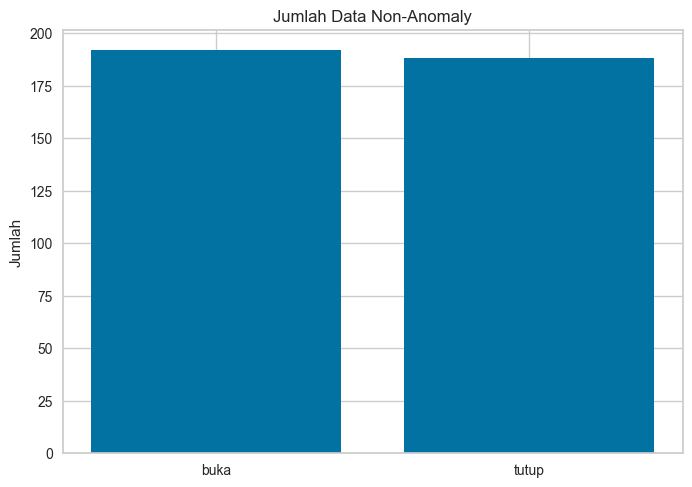

,buka,tutup
0,192,188


In [81]:
import matplotlib.pyplot as plt

buka_non_anomaly = non_anomaly_data[non_anomaly_data["label"] == "buka"]
tutup_non_anomaly = non_anomaly_data[non_anomaly_data["label"] == "tutup"]

plt.bar(["buka", "tutup"], [buka_non_anomaly.shape[0], tutup_non_anomaly.shape[0]])

plt.title("Jumlah Data Non-Anomaly")
plt.ylabel("Jumlah")


plt.show()

pd.DataFrame([[buka_non_anomaly.shape[0], tutup_non_anomaly.shape[0]]], columns=["buka", "tutup"])

### Korelasi Fitur

In [82]:
def corel_check(x, y, treshold):
    data_res = []
    corel_arr = []
    for data in x:
        corel = np.mean(np.corrcoef(x[data], y))
        # corel = corelation(x[data], y)
        corel_arr.append(corel)
        if corel > treshold or (corel < 0 - treshold and corel < 0):
            data_res.append(data)
    return data_res

In [83]:
label = non_anomaly_data["label"].map({
    'buka': 0,
    'tutup': 1
})
fitur = non_anomaly_data.drop("label", axis=1).drop("Anomaly_Score", axis=1).drop("Anomaly", axis=1)

In [84]:
fitur_bearkorelasi = corel_check(fitur, label, 0.6)
len(fitur_bearkorelasi)

22

In [85]:
fitur_bearkorelasi

['mfcc_mean_3',
 'mfcc_mean_4',
 'mfcc_std_8',
 'centroid_std_1',
 'mel_mean_9',
 'mel_mean_14',
 'mel_mean_15',
 'mel_mean_16',
 'mel_mean_17',
 'mel_mean_18',
 'mel_mean_101',
 'mel_mean_102',
 'mel_mean_103',
 'mel_std_9',
 'mel_std_12',
 'mel_std_14',
 'mel_std_17',
 'mel_std_18',
 'mel_std_100',
 'mel_std_101',
 'mel_std_102',
 'mel_std_103']

### Model Training

In [86]:
dataset = pd.read_csv("./dataset/clean.csv")

X = dataset[fitur_bearkorelasi]
y = dataset["label"]

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(scaler.transform(X_test))

In [87]:
accuracy_score(y_test, y_pred)

0.9868421052631579

### Menyimpan Model

In [88]:
# joblib.dump(rf_model, "../../audio_streamlit/svm.pkl")
# joblib.dump(scaler, "../../audio_streamlit/scale.pkl")

In [89]:
# joblib.dump(fitur_bearkorelasi, '../../audio_streamlit/fitur_berkorelasi.pkl')
# joblib.dump(columns[0:-1], '../../audio_streamlit/columns.pkl')

In [ ]:
a = [1, 1, 1, 1]